# ARIMA Predictions

## Temperature Predictions

In [27]:
# general data manipulation libraries
import pandas as pd # for data manipulation
import numpy as np # for numerical operations
from sklearn.metrics import mean_squared_error, mean_absolute_error # for model evaluation

# general data visualization libraries
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# for time series analysis
from statsmodels.tsa.stattools import adfuller # for ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # for ACF and PACF plots
from statsmodels.tsa.seasonal import MSTL    # For seasonal decomposition of time series

# for ARIMA modeling
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [28]:
# import the data
path = 'raw_temperature.csv'
df_temperature = pd.read_csv(path)

df_temperature.head()

,datetime,Pittsburgh,Chicago
0,2012-10-01 12:00:00,NaN,NaN
1,2012-10-01 13:00:00,281.000000,284.010000
2,2012-10-01 14:00:00,281.024767,284.054691
3,2012-10-01 15:00:00,281.088319,284.177412
4,2012-10-01 16:00:00,281.151870,284.300133


In [29]:
# check for missing values
df_temperature.isnull().sum()

datetime      0
Pittsburgh    3
Chicago       3
dtype: int64

In [30]:
# set datetime as datetime format
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'])

# set datetime as index
df_temperature.set_index('datetime', inplace=True)

# specify the frequency of the data as hourly
df_temperature = df_temperature.asfreq('h')

Due to daylight saving time we have 2 missing values in the middle of the dataset that we proceed to fill them with the avg values in between. We remove the first row.

In [31]:
# fill missing values with average between adjacent values
df_temperature['Pittsburgh'] = df_temperature['Pittsburgh'].interpolate(method='linear')

# remove first row
df_temperature = df_temperature.drop(df_temperature.index[0])

# check again
df_temperature.isnull().sum()

Pittsburgh    0
Chicago       2
dtype: int64

In [32]:
# separate the dataset into two datasets
df_temperature_pittsburgh = df_temperature['Pittsburgh'].copy()

# transform from kelvin into celcius
df_temperature_pittsburgh = df_temperature_pittsburgh - 273.15

### ARIMA Model Order Selection

### Stationarity

In order to perform [autoregressive integral moving average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), we need the data to be stationary. The temperature presents two seasonalities: daily (24-hour) and yearly (24 hour * 365 = 8760 hour):


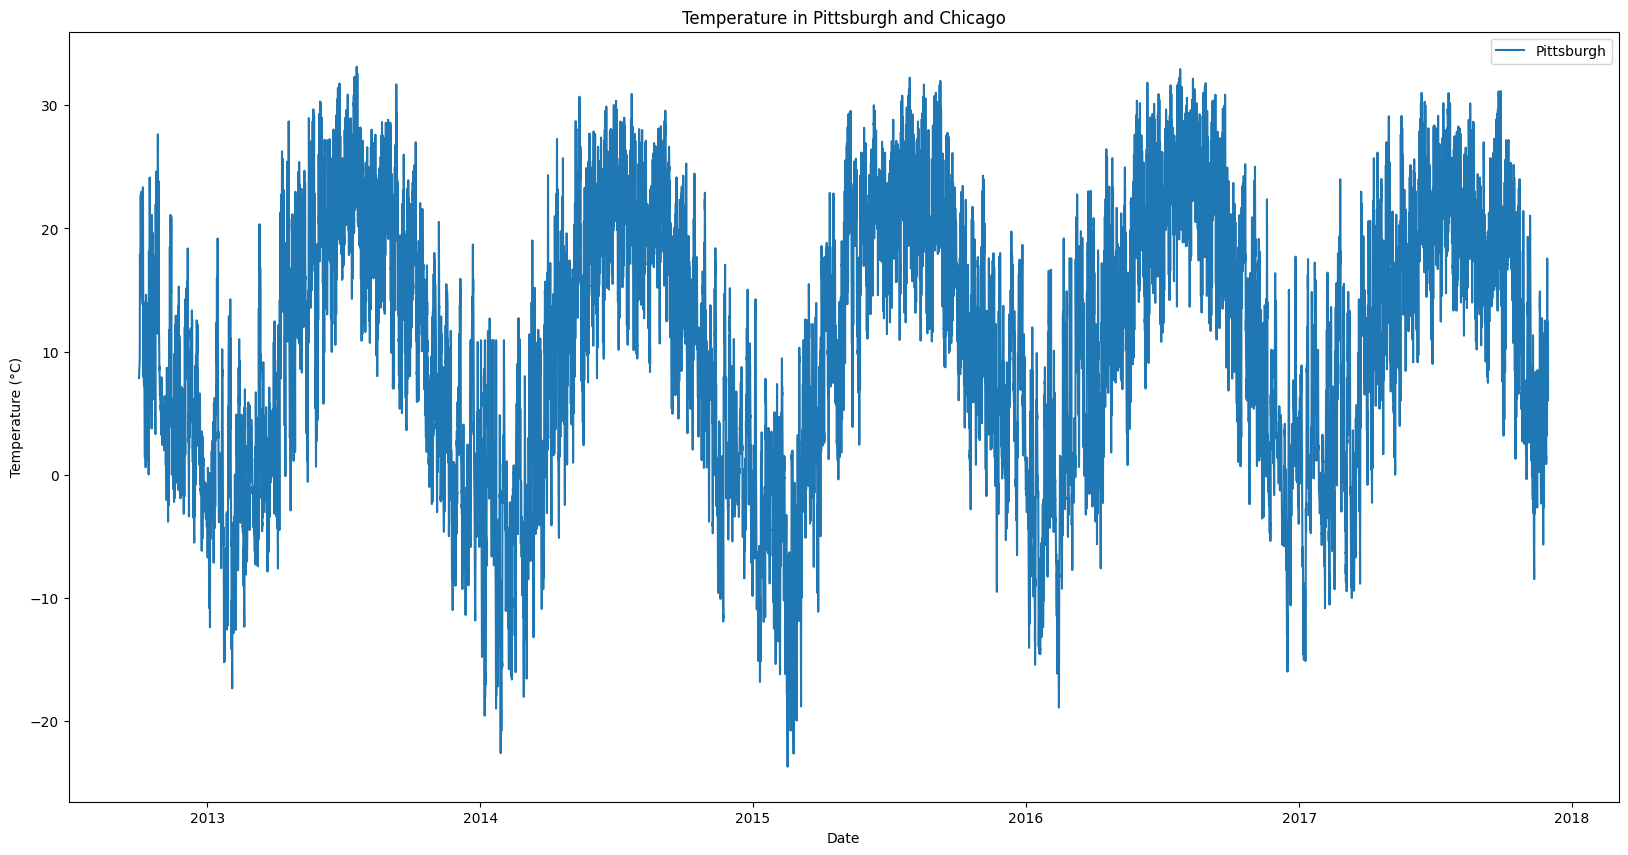

In [33]:
# create figure
plt.figure(figsize=(20, 10))

# plot the data
sns.lineplot(data=df_temperature_pittsburgh, label='Pittsburgh')

# set title and labels
plt.title('Temperature in Pittsburgh and Chicago')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

We separate the data into train and test sets:

In [34]:
# date to split the data
split_date = '2017-01-01'

# split the data
df_train = df_temperature_pittsburgh.loc[df_temperature_pittsburgh.index < split_date]
df_test = df_temperature_pittsburgh.loc[df_temperature_pittsburgh.index >= split_date]

Proceed to perform [MSTL](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html#):

In [35]:
# instantitate the MSTL model to find multi seasonality
mstl = MSTL(
    df_train, 
    periods=[24, 24*365], # daily and yearly seasonality
    iterate=2, # number of iterations
    stl_kwargs={'seasonal_deg':0} # seasonal smoothing 0
    )
result = mstl.fit()

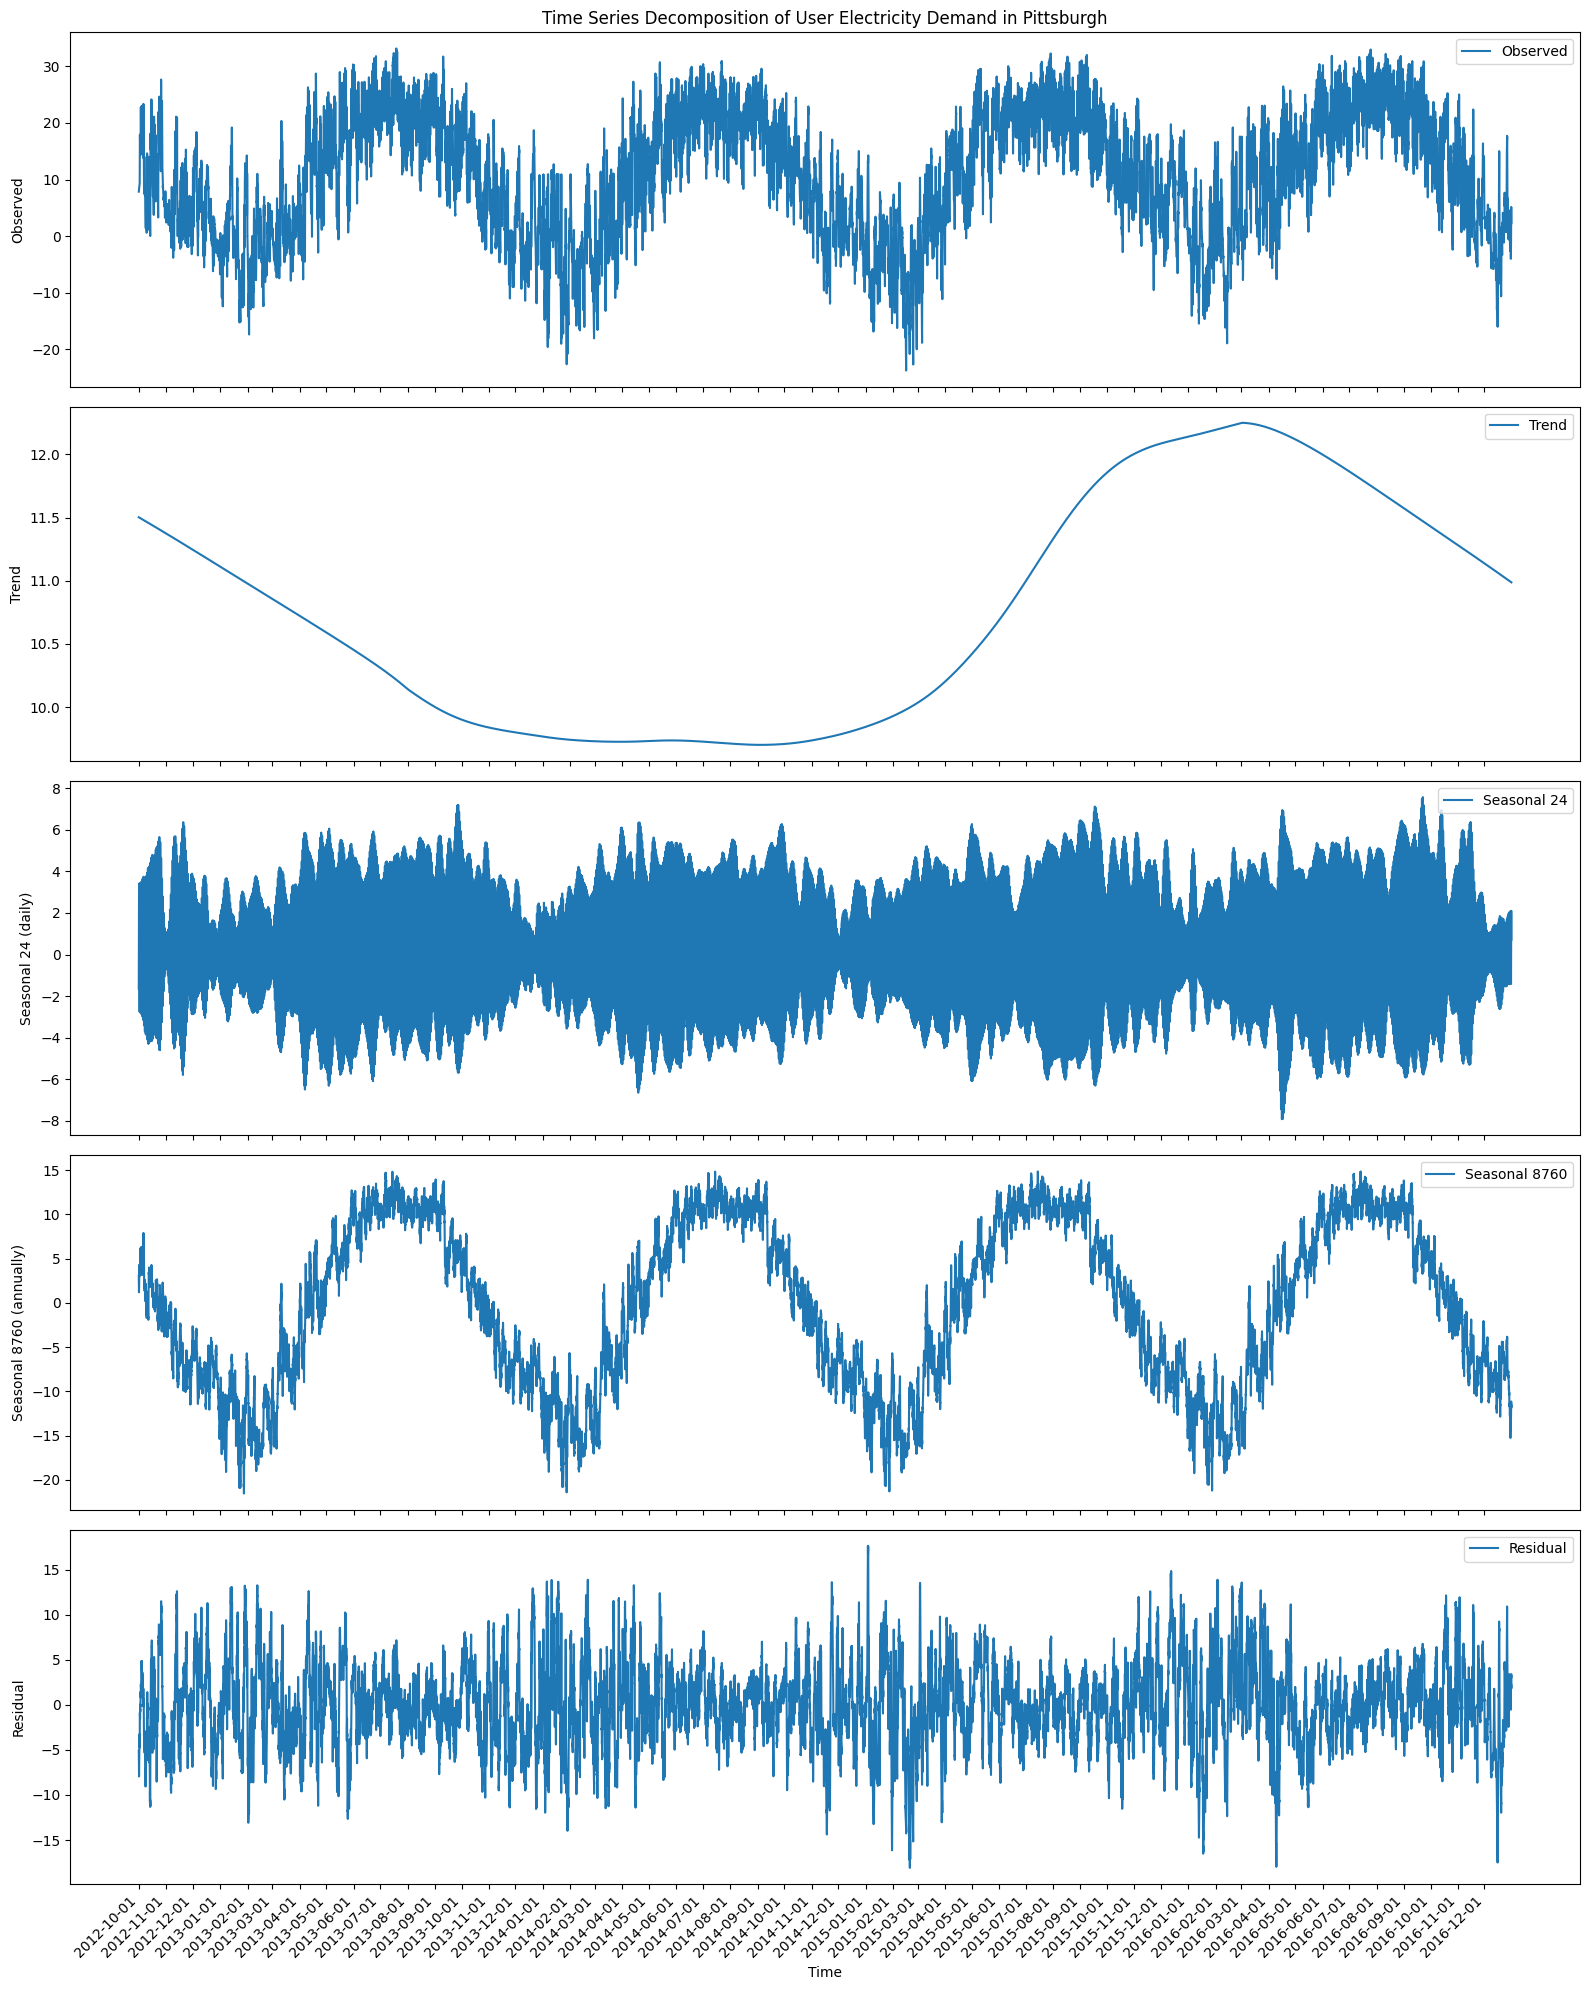

In [36]:
# create 5 subplots
fig, axs = plt.subplots(5, 1, figsize=(16, 20), sharex=True)

# plot each component
sns.lineplot(data=result.observed, ax=axs[0], label='Observed')
sns.lineplot(data=result.trend, ax=axs[1], label='Trend')
sns.lineplot(data=result.seasonal['seasonal_24'], ax=axs[2], label='Seasonal 24')
sns.lineplot(data=result.seasonal['seasonal_8760'], ax=axs[3], label='Seasonal 8760')
sns.lineplot(data=result.resid, ax=axs[4], label='Residual')

# set labels and title
axs[0].set_ylabel('Observed')
axs[1].set_ylabel('Trend')
axs[2].set_ylabel('Seasonal 24 (daily)')
axs[3].set_ylabel('Seasonal 8760 (annually)')
axs[4].set_ylabel('Residual')
axs[0].set_title('Time Series Decomposition of User Electricity Demand in Pittsburgh')

# add legends
for ax in axs:
    ax.legend(loc='upper right')

# set x axis ticks and labels
ax_last = axs[-1]
ax_last.set_xlabel('Time')

# create date range for x axis ticks
start_date = result.observed.index[0]
end_date = result.observed.index[-1]
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

ax_last.set_xticks(date_range)

# customize x axis label formatting
def format_date(x, pos=None):
    date = pd.to_datetime(x)
    if date.month == 1:
        return date.strftime('%Y %b')
    else:
        return date.strftime('%b')

# rotate and align the tick labels
plt.setp(ax_last.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Proceed to perform [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to check stationarity:

In [37]:
# create df with decomposed data
df_trend = result.trend
df_seasonal_24 = result.seasonal['seasonal_24']
df_seasonal_8760 = result.seasonal['seasonal_8760']
df_residual = result.resid

In [38]:
# check for stationarity on trend
adf_test_trend = adfuller(df_trend)
print('## Trend ##')
print('ADF Statistic: %f' % adf_test_trend[0])
print('p-value: %f' % adf_test_trend[1])
print('Critical Values:')
for key, value in adf_test_trend[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test_trend[1] > 0.05:
    print('Trend is not stationary')
else:
    print('Trend is stationary')


# check for stationarity on seasonal 24
adf_test_seasonal_24 = adfuller(df_seasonal_24)
print('\n## Seasonal 24 ##')
print('ADF Statistic: %f' % adf_test_seasonal_24[0])
print('p-value: %f' % adf_test_seasonal_24[1])
print('Critical Values:')
for key, value in adf_test_seasonal_24[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test_seasonal_24[1] > 0.05:
    print('Seasonal 24 is not stationary')
else:
    print('Seasonal 24 is stationary')


# check for stationarity on seasonal 8760
adf_test_seasonal_8760 = adfuller(df_seasonal_8760)
print('\n## Seasonal 8760 ##')
print('ADF Statistic: %f' % adf_test_seasonal_8760[0])
print('p-value: %f' % adf_test_seasonal_8760[1])
print('Critical Values:')
for key, value in adf_test_seasonal_8760[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test_seasonal_8760[1] > 0.05:
    print('Seasonal 8760 is not stationary')
else:
    print('Seasonal 8760 is stationary')


# check for stationarity on residual
adf_test_residual = adfuller(df_residual)
print('\n## Residual ##')
print('ADF Statistic: %f' % adf_test_residual[0])
print('p-value: %f' % adf_test_residual[1])
print('Critical Values:')
for key, value in adf_test_residual[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_test_residual[1] > 0.05:
    print('Residual is not stationary')
else:
    print('Residual is stationary')

## Trend ##
ADF Statistic: -11.553764
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Trend is stationary

## Seasonal 24 ##
ADF Statistic: -34.996725
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Seasonal 24 is stationary

## Seasonal 8760 ##
ADF Statistic: -3.271836
p-value: 0.016185
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Seasonal 8760 is stationary

## Residual ##
ADF Statistic: -16.206100
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Residual is stationary


After confirming the stationarity of our time series through the ADF test, we now need to determine the optimal order for our ARIMA model. The ARIMA order is represented by (p,d,q), where:

- $p$: The order of the autoregressive (AR) term. Obtained from the partial autocorrelation function (PACF) plot.
- $d$: The degree of differencing. When stationary $\rightarrow d = 0$ (as is the case for all components). If we need to difference once (to obtain stationarity) then $d = 1$.
- $q$: The order of the moving average (MA) term. Obtained from the autocorrelation function (ACF) plot.

Trend order test:

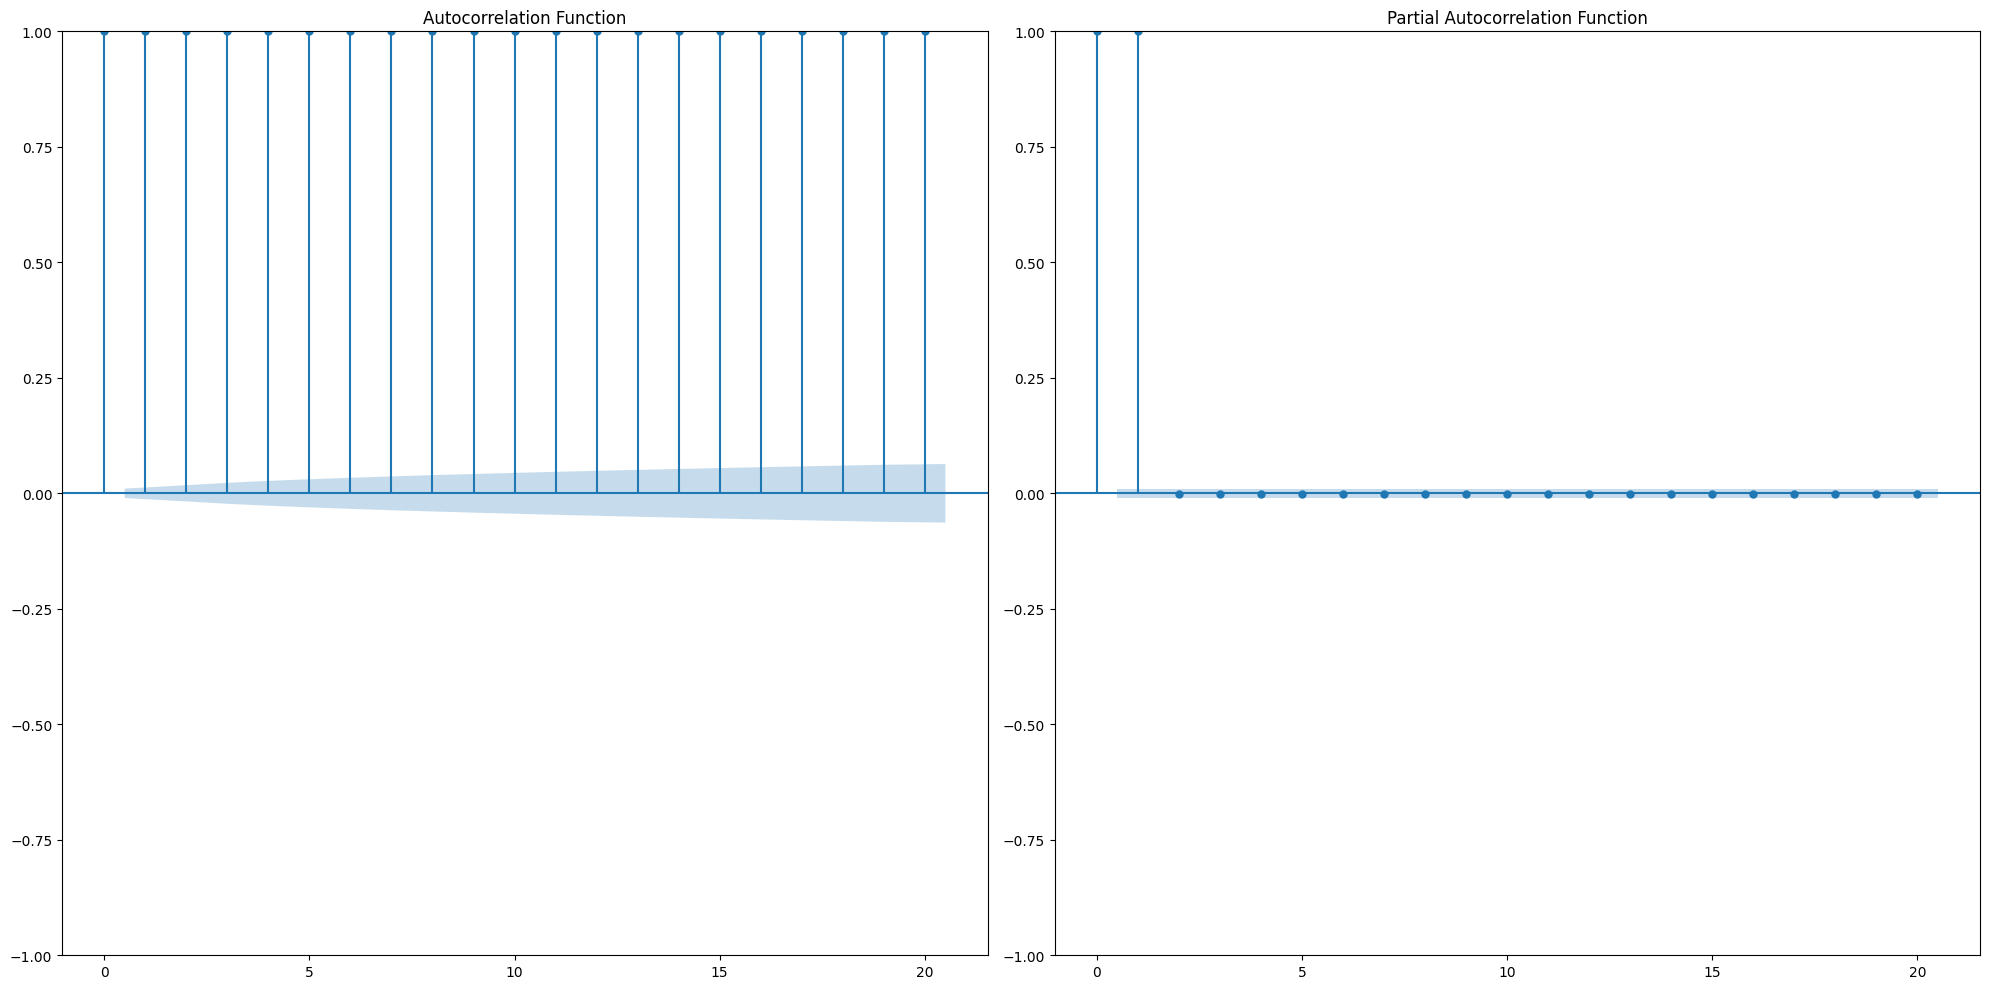

In [39]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_trend, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_trend, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

Due to the length of the dataset, the 95% CI bands are very narrow for a 24-hour lag and all the points fall outside them. **Which is good**, autocorrelations that exceed the upper or lower CI bands are considered statistically significant; lags inside the bands are considered random noise and not meaningful for model selection.

The best (temptative) values are $p=q=1$.

Seasonal 24 order test:

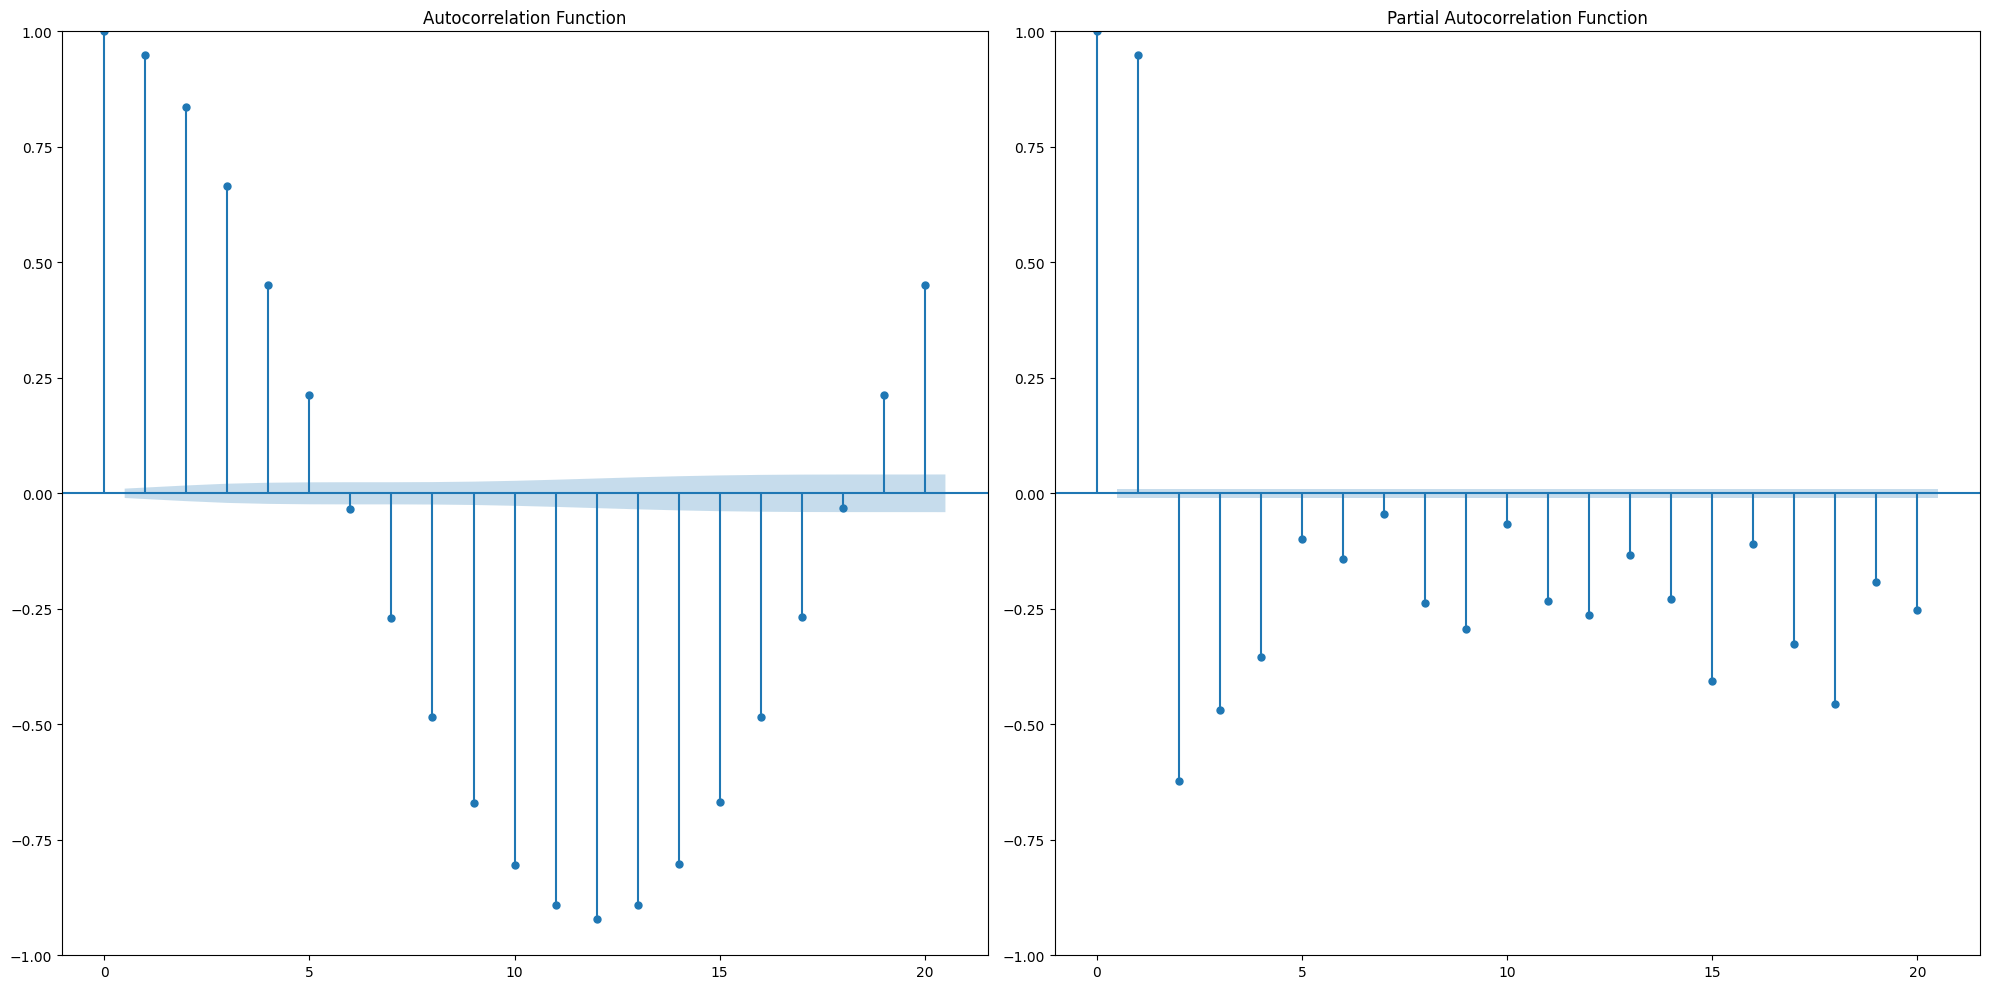

In [40]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_seasonal_24, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_seasonal_24, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

The best (temptative) values are $p=q=1$.

Seasonal 8760 order test:

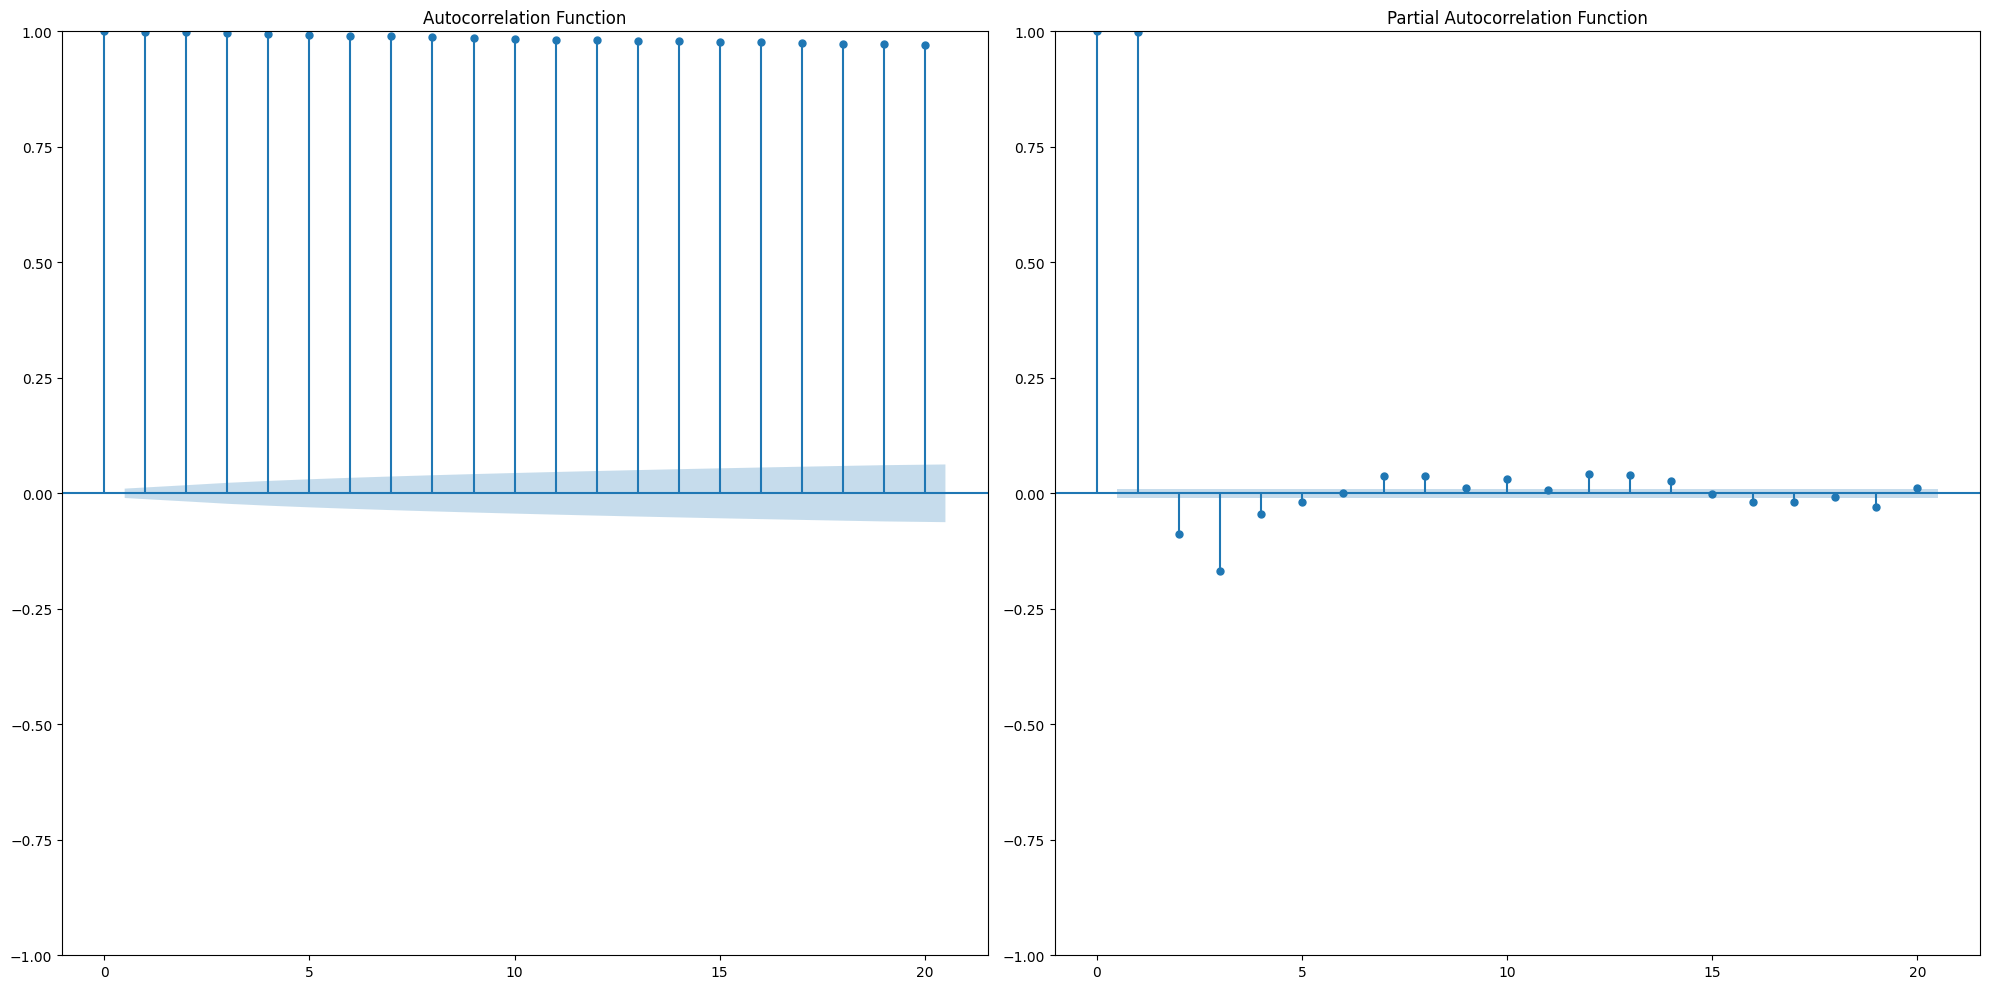

In [41]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_seasonal_8760, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_seasonal_8760, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

The best (temptative) values are $p=q=1$.

Residual order test:

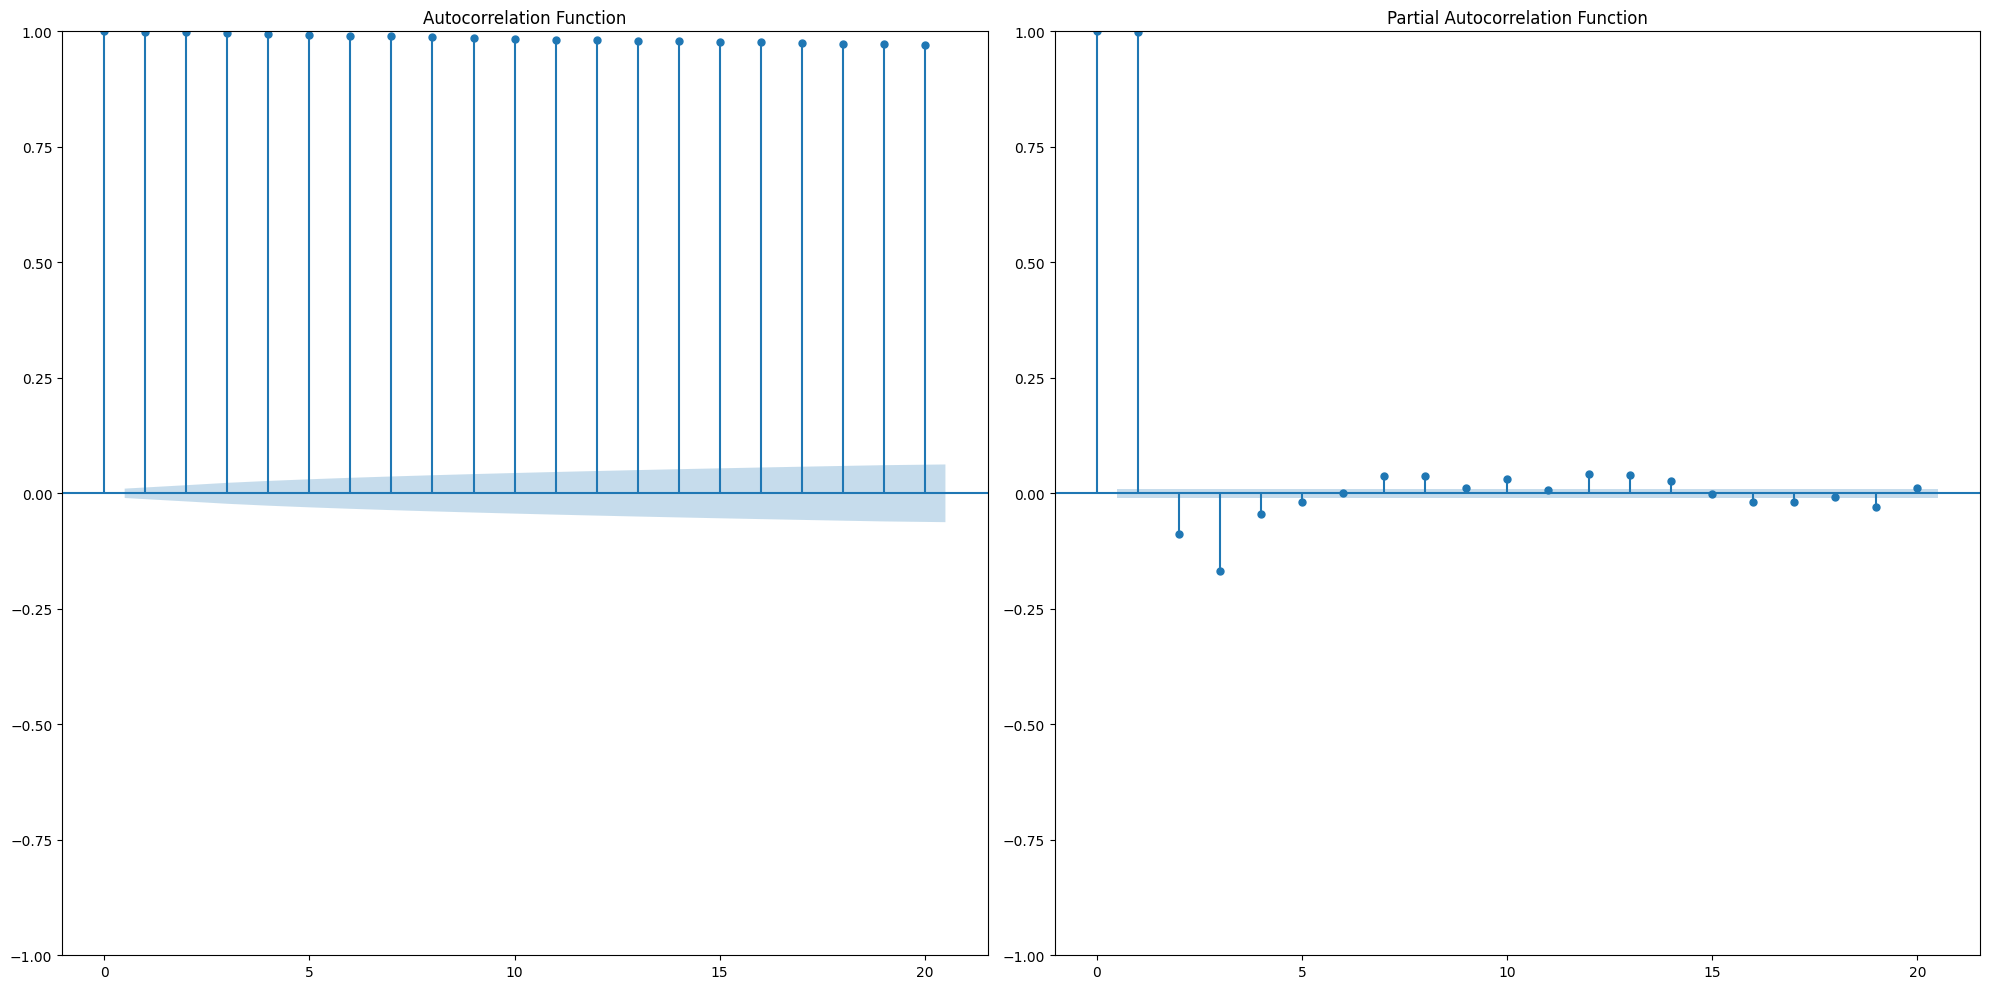

In [42]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_seasonal_8760, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_seasonal_8760, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

The best (temptative) values are $p=q=1$.

Also for the whole dataset we get the same:

In [43]:
# ADF test for Pittsburgh
adf_pittsburgh = adfuller(df_train)
print('Pittsburgh')
print('ADF Statistic: %f' % adf_pittsburgh[0])
print('p-value: %f' % adf_pittsburgh[1])
print('Critical Values:')
for key, value in adf_pittsburgh[4].items():
    print('\t%s: %.3f' % (key, value))

Pittsburgh
ADF Statistic: -7.653189
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


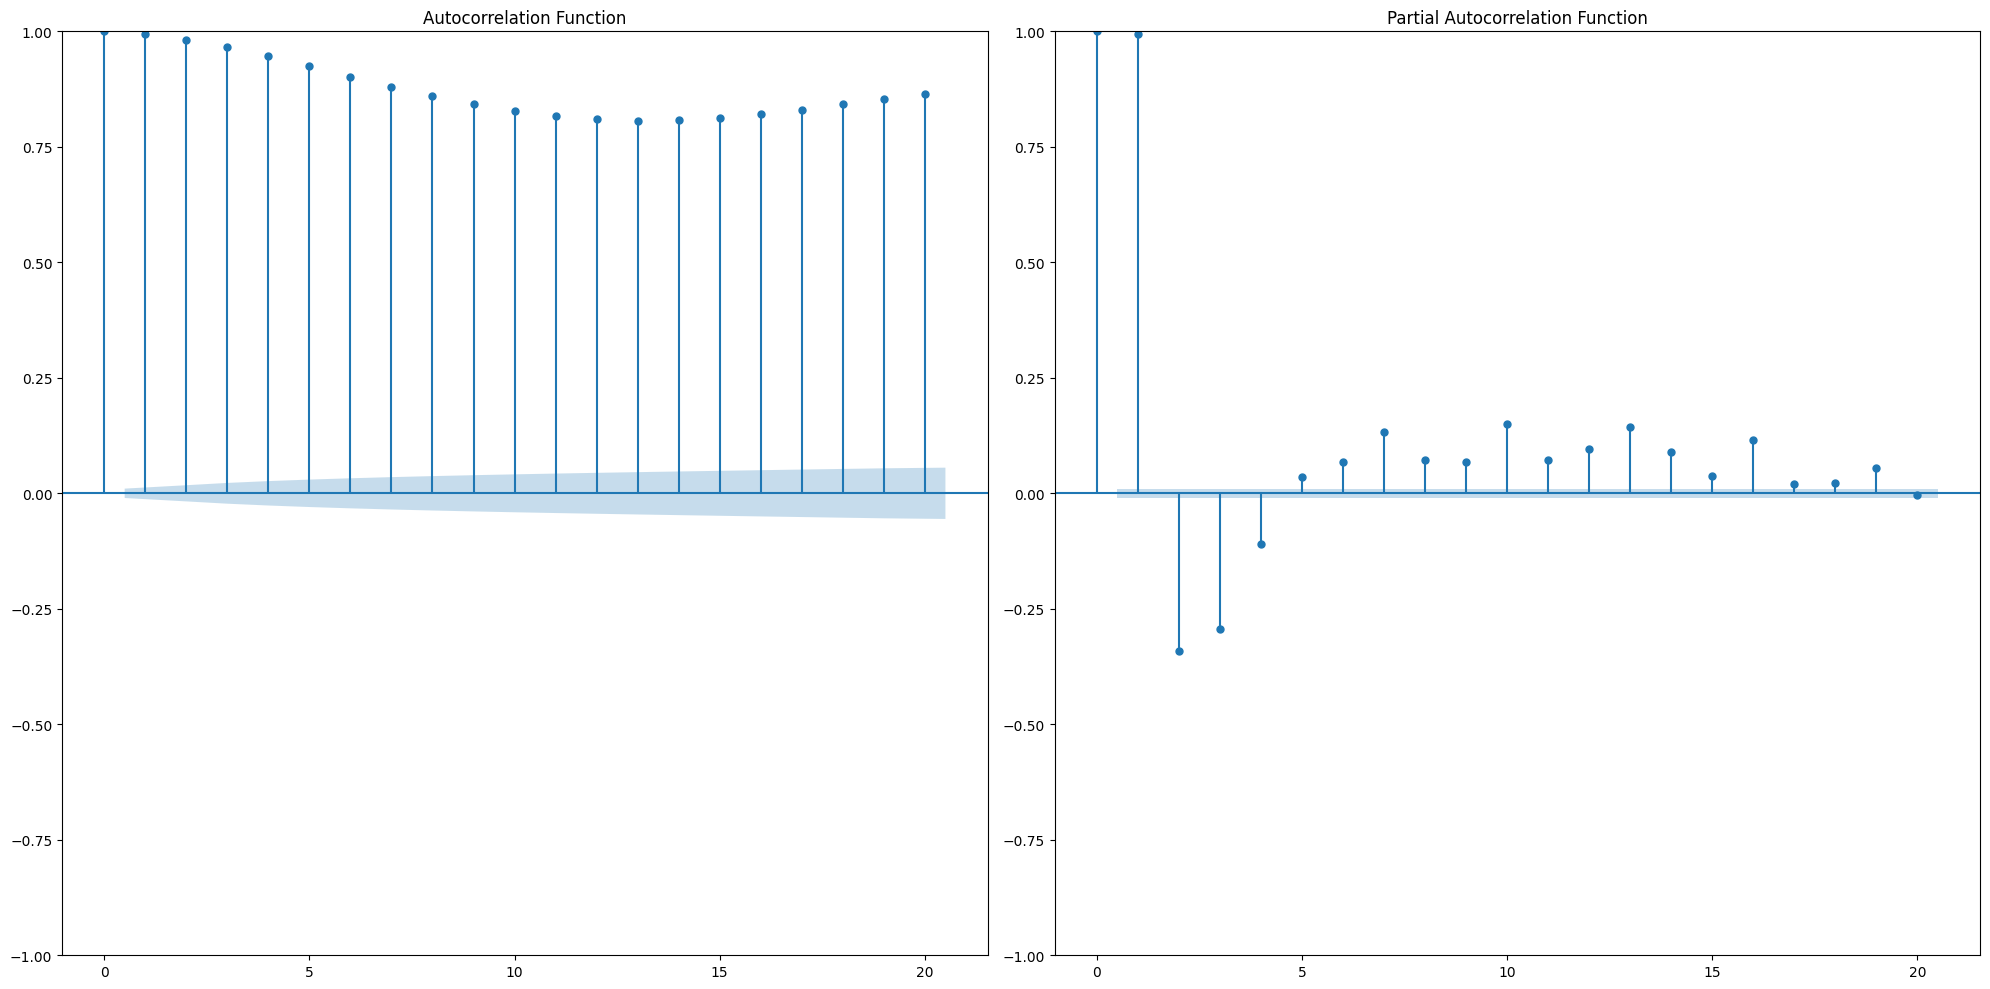

In [44]:
# determine lag steps
n_lags = 20

# close any existing plots first
plt.close('all')

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# suppress the automatic figure creation by plot_acf and plot_pacf
with plt.ioff():
    plot_acf(df_train, lags=n_lags, ax=ax1)
    ax1.set_title('Autocorrelation Function')

    plot_pacf(df_train, lags=n_lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function')

# adjust layout
plt.tight_layout()
plt.show()

The best (temptative) values are $p=q=1$.

Since the seasonal components are periodic, can be directly applied to future data points.

The trend component can be modeled and forecasted using ARIMA (or another model).

The residual represents noise and should be modeled using ARIMA (or ignored if purely random).

In [45]:
# fit ARIMA on residuals
model_residual = ARIMA(df_residual.dropna(), order=(1, 0, 1))
fit_residual = model_residual.fit()
residual_forecast = fit_residual.forecast(steps=len(df_test))

In [46]:
import warnings

# Suppress only the specific warning about non-stationary starting autoregressive parameters
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")

In [47]:
# fit ARIMA on trend
# model_trend = ARIMA(df_trend.dropna(), order=(1, 1, 1)) # this won't converge
model_trend = ARIMA(df_trend.dropna(), order=(1, 1, 1)) # still non-stationary but with differencing for convergency
fit_trend = model_trend.fit()
trend_forecast = fit_trend.forecast(steps=len(df_test))

The seasonal data is only available for the training set. Therefore, we need to extend it to ensure the continuity of the forecast series. In simpler terms, the end of the training forecast should coincide with the beginning of the forecast on the test set.

In [48]:
# calculate total hours and days between train and test
hours_between = (df_test.index[0] - df_train.index[-1]).total_seconds() / 3600
days_between = (df_test.index[0] - df_train.index[-1]).days

# 3-month offset (approximate 90 days)
months_offset_hours = int(90 * 24)  # 90 days * 24 hours

# apply offsets to seasonal components
seasonal_24_forecast = np.tile(df_seasonal_24.values, int(np.ceil(len(df_test) / 24)))
seasonal_24_forecast = seasonal_24_forecast[months_offset_hours:months_offset_hours + len(df_test)]

seasonal_8760_forecast = np.tile(df_seasonal_8760.values, int(np.ceil(len(df_test) / 8760)))
seasonal_8760_forecast = seasonal_8760_forecast[months_offset_hours:months_offset_hours + len(df_test)]

In [49]:
# combine components
forecast_combined = trend_forecast + seasonal_24_forecast + seasonal_8760_forecast + residual_forecast
forecast_combined_seasons = seasonal_24_forecast + seasonal_8760_forecast
# forecast_combined = trend_forecast + residual_forecast

In [50]:
# compare the forecast with the test data
mae = mean_absolute_error(df_test, forecast_combined)
mse = mean_squared_error(df_test, forecast_combined)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

MAE: 6.809369217358785, MSE: 70.00775060611795, RMSE: 8.367063439828692


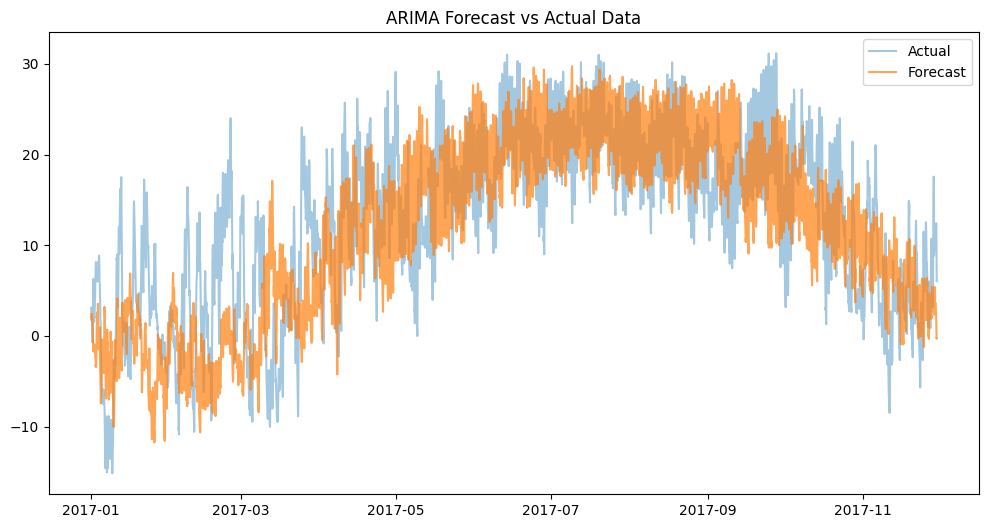

In [51]:
# create figure
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test, label='Actual', alpha=0.4)
plt.plot(df_test.index, forecast_combined, label='Forecast', alpha=0.7)
plt.legend()
plt.title("ARIMA Forecast vs Actual Data")
plt.show()

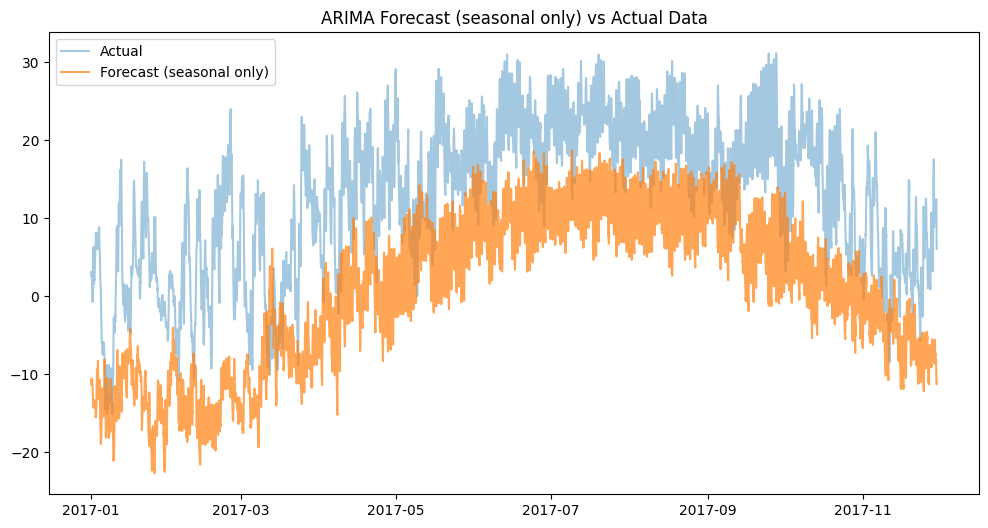

In [52]:
# create figure
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test, label='Actual', alpha=0.4)
plt.plot(df_test.index, forecast_combined_seasons, label='Forecast (seasonal only)', alpha=0.7)
plt.legend()
plt.title("ARIMA Forecast (seasonal only) vs Actual Data")
plt.show()